In [216]:
#########1#########2#########3#########4#########5#########6#########7#########
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [217]:
seds = pd.read_csv('../data/seds_residents.csv')
seds['log_nu'] = np.log10(seds['Frequency (Hz)'])
seds['log_nufnu'] = np.log10(seds['Nufnu (erg cm^-2 s^-1)'])
#seds.head()

In [218]:
bzcat = pd.read_csv('../data/BZCAT_RESULT.csv')

# "Mutual" source names for the datasets
bzcat['Source'] = bzcat.apply(lambda x:
    x['RA (J2000.0)'][0:2] + x['RA (J2000.0)'][3:5] + x['RA (J2000.0)'][6:8] \
    + x['Dec (J2000.0)'][0:3] + x['Dec (J2000.0)'][4:6] + x['Dec (J2000.0)'][7:9], 
    axis=1)
seds = pd.merge(seds, bzcat[['Source', 'Redshift', 'cluster']], on='Source')
#seds.head()

In [219]:
# To rest frame
seds['log_nu'] = seds['log_nu'] + np.log10(1 + seds['Redshift'])
seds['log_nufnu'] = seds['log_nufnu'] + np.log10(1 + seds['Redshift'])
seds.head()

,Source,Frequency (Hz),Bin,Nufnu (erg cm^-2 s^-1),Nufnu_err,TStart,TStop,Comment,log_nu,log_nufnu,Redshift,cluster
0,000020-322101,8.430000e+08,0.0,2.710200e-15,8.261400e-17,50600.5,52974.5,NaN,9.282809,-14.210017,1.275,4
1,000020-322101,1.400000e+09,0.0,7.299700e-15,2.190700e-16,49231.5,50508.5,NaN,9.503109,-13.779714,1.275,4
2,000020-322101,2.700000e+09,0.0,1.458000e-14,0.000000e+00,40587.5,47892.5,NaN,9.788345,-13.479261,1.275,4
3,000020-322101,2.700000e+09,0.0,1.458000e-14,0.000000e+00,0.0,0.0,NaN,9.788345,-13.479261,1.275,4
4,000020-322101,4.850000e+09,0.0,2.594700e-14,1.891500e-15,48043.5,48196.5,NaN,10.042723,-13.228931,1.275,4


In [220]:
def norm_spectrum(seds, source):
    "Normalized spectrum for a single source"
    PEAK_RBOUND = 17.5 
    sed = seds[seds['Source'] == source][['log_nu', 'log_nufnu']]
    smax = sed[sed['log_nu'] < PEAK_RBOUND]['log_nufnu'].max()
    sed['log_nufnu_norm'] = sed['log_nufnu'] - smax 
        
    return sed


def norm_spectra(seds, cluster):
    "Normalized spectra for a cluster"
    PEAK_RBOUND = 17.5 
    seds = seds[seds['cluster'] == cluster][['Source', 'log_nu', 'log_nufnu']]
    
    # Max log_nufnu at log_nu < PEAK_RBOUND
    seds['temp_col'] = seds['log_nufnu']
    mask = seds['log_nu'] > PEAK_RBOUND
    seds.loc[mask, 'temp_col'] = -np.inf
    seds['max'] = seds.groupby('Source')['temp_col'].transform('max')
    
    seds['log_nufnu_norm'] = seds['log_nufnu'] - seds['max']
        
    return seds


def aver_spectrum(seds, cluster, bins=50):
    "Average spectrum for a cluster"
    seds = norm_spectra(seds, cluster)
    seds['mean'] =(
        seds['log_nufnu_norm']
        .groupby(pd.cut(seds['log_nu'], bins, include_lowest=True, labels=False))
        .transform('mean'))
            
    return seds


def print_norm_spectra(seds):
    "Print normalized spectra per each cluster"
    norm_spectra_list = []
    clusters = sorted(seds['cluster'].unique())
    for cl in clusters: 
        norm_spectra_list.append(norm_spectra(seds, cl))
    n_cl = len(clusters)
    fig, ax = plt.subplots(1, n_cl, figsize=(8*n_cl, 5))
    for axi, cl in zip(ax.flatten(), clusters):
        axi.scatter(norm_spectra_list[cl]['log_nu'], 
                    norm_spectra_list[cl]['log_nufnu_norm'])
    fname = '../figs/all_measurements_norm.png' 
    plt.savefig(fname)    
        

def print_aver_spectra(seds, bins=50):
    "Print average spectrum per each cluster"
    aver_spectra = []
    clusters = sorted(seds['cluster'].unique())
    for cl in clusters: 
        aver_spectra.append(aver_spectrum(seds, cl, bins=bins))
    n_cl = len(clusters)
    fig, ax = plt.subplots(1, n_cl, figsize=(8*n_cl, 5))
    for axi, cl in zip(ax.flatten(), clusters):
        axi.scatter(aver_spectra[cl]['log_nu'], aver_spectra[cl]['mean'])
    fname = '../figs/aver_sp_bin' + str(bins) + '.png' 
    plt.savefig(fname)    

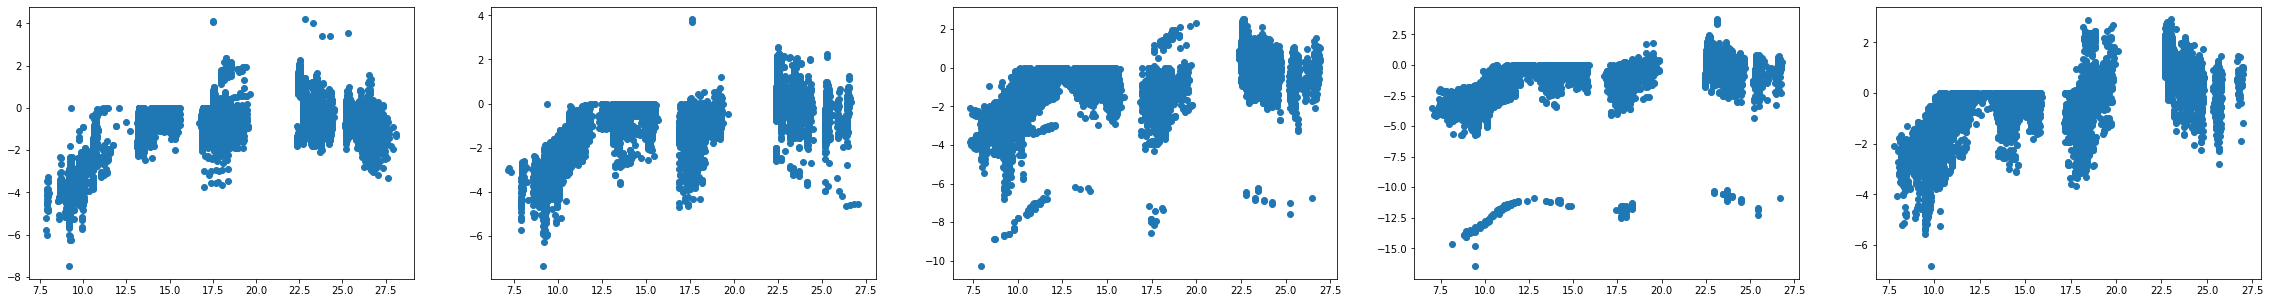

In [221]:
print_norm_spectra(seds)

In [222]:
# Drop outliers
norm_sp2 = norm_spectra(seds, 2)
norm_sp3 = norm_spectra(seds, 3)
print(norm_sp2[norm_sp2['log_nufnu_norm'] < -8]['Source'].unique())
print(norm_sp3[norm_sp3['log_nufnu_norm'] < -8]['Source'].unique())

seds = seds[seds['Source'] != '141558+132023']
seds = seds[seds['Source'] != '090910+012135']

['141558+132023']
['090910+012135']


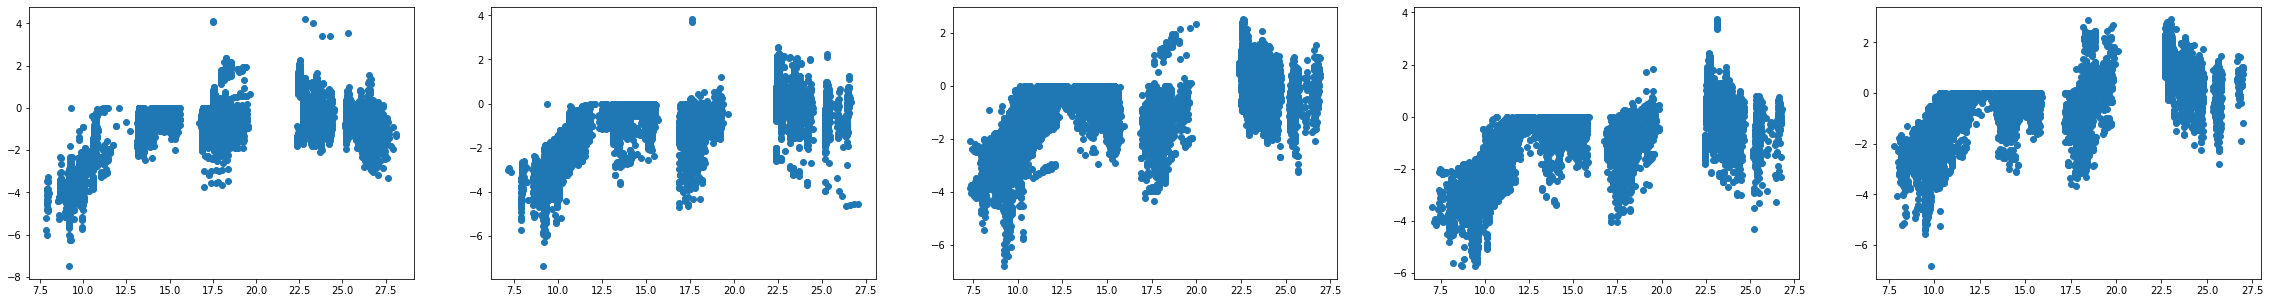

In [223]:
print_norm_spectra(seds)

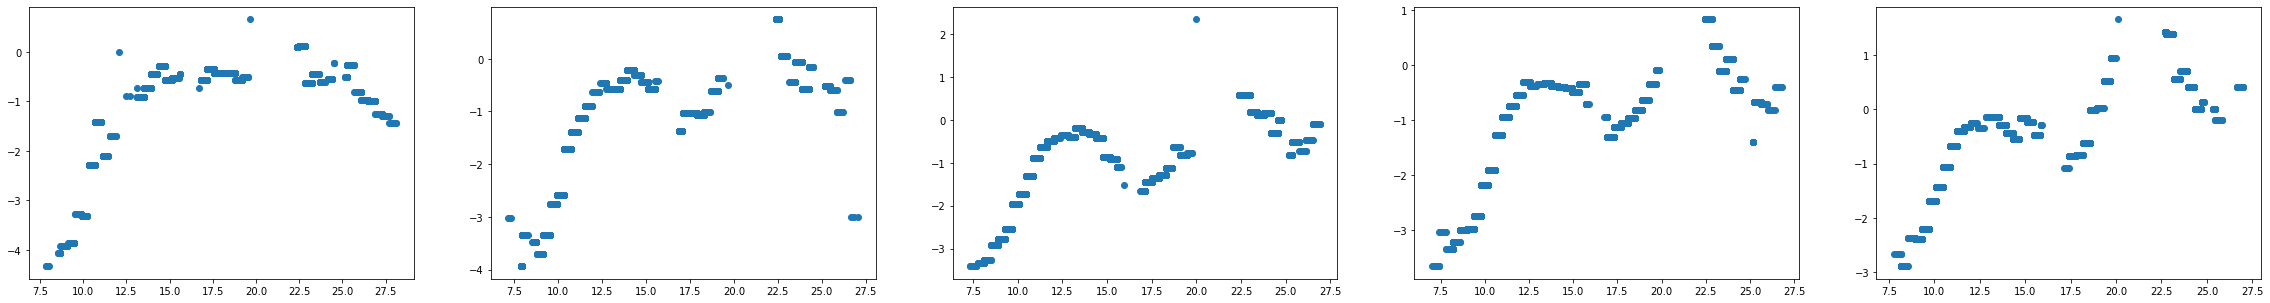

In [224]:
print_aver_spectra(seds, bins=50)

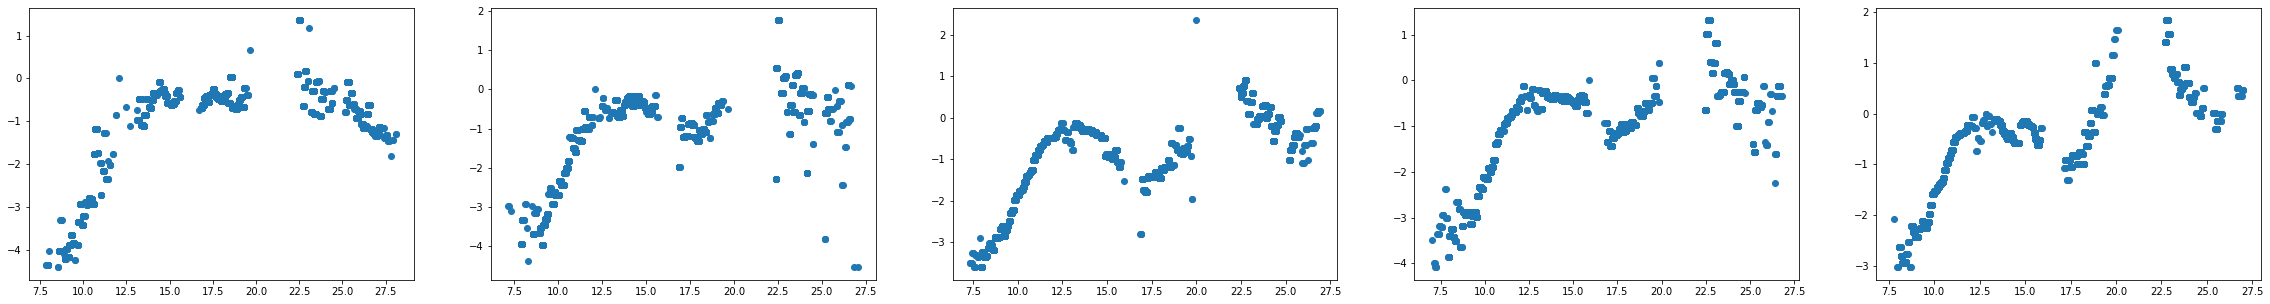

In [225]:
print_aver_spectra(seds, bins=200)